Columns of region_encoded: Index(['Region_C0001', 'Region_C0002', 'Region_C0003', 'Region_C0004',
       'Region_C0005', 'Region_C0006', 'Region_C0007', 'Region_C0008',
       'Region_C0009', 'Region_C0010',
       ...
       'Region_C0195', 'Region_C0196', 'Region_C0197', 'Region_C0198',
       'Region_C0199', 'Region_C0200', 'Region_Asia', 'Region_Europe',
       'Region_North America', 'Region_South America'],
      dtype='object', length=204)
Columns of rfm: Index(['CustomerID', 'TransactionDate', 'Frequency', 'Monetary', 'Recency'], dtype='object')
Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Index(['Region_C0001', 'Region_C0002', 'Region_C0003', 'Region_C0004',
       'Region_C0005', 'Region_C0006', 'Region_C0007', 'Region_C0008',
       'Region_C0009', 'Region_C0010',
       ...
       'Region_C0195', 'Region_C0196', 'Region_C0197', 'Region_C0198',
       'Region_C0199', 'Region_C0200', 'Region_Asia', 'Region_Europe',
       'Region_North America

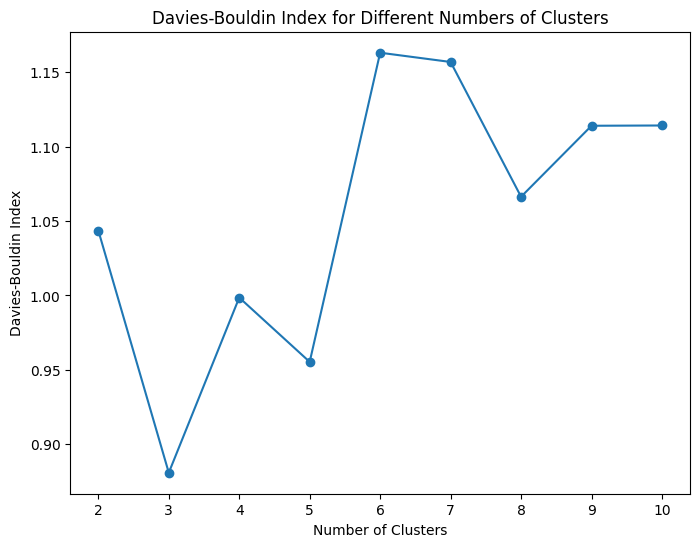

Optimal number of clusters: 3
Silhouette Score: 0.383298618036826
Inertia: 233.13735868090697


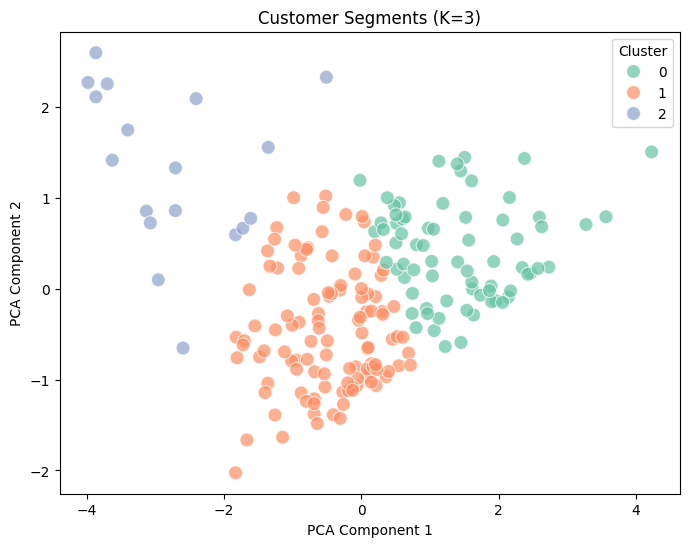

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Step 1: Load the data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

# Step 2: Preprocessing Data
# Ensure that the 'TransactionDate' is in datetime format
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# One-hot encode 'Region' (Content-based feature) and include CustomerID
region_encoded = pd.get_dummies(customers[['CustomerID', 'Region']], prefix='Region')

# Check the columns of region_encoded to ensure 'CustomerID' is retained
print("Columns of region_encoded:", region_encoded.columns)

# Aggregate transaction data to create RFM features (Recency, Frequency, Monetary)
rfm = transactions.groupby('CustomerID').agg({
    'TransactionDate': 'max',  # Recency
    'TransactionID': 'count',  # Frequency
    'TotalValue': 'sum'  # Monetary
}).reset_index()

# Calculate recency as the days since the last transaction
rfm['Recency'] = (pd.to_datetime('today') - pd.to_datetime(rfm['TransactionDate'])).dt.days

# Rename the columns for better clarity
rfm = rfm.rename(columns={'TransactionID': 'Frequency', 'TotalValue': 'Monetary'})

# Check the columns of rfm to ensure 'CustomerID' is included
print("Columns of rfm:", rfm.columns)
print(customers.columns)  # Check columns in customers DataFrame
print(region_encoded.columns)  # Check columns in region_encoded DataFrame
print(rfm.columns)  # Check columns in rfm DataFrame


# Step 3: Merge Region-based features and RFM features with the customer data
# Ensure 'CustomerID' is of the same type in both DataFrames
customers['CustomerID'] = customers['CustomerID'].astype(str)
# Step 1: Ensure CustomerID is in region_encoded
region_encoded['CustomerID'] = customers['CustomerID']

# Step 2: Merge the region_encoded DataFrame with customers
customers_data = pd.merge(customers, region_encoded, on='CustomerID', how='left')

# Step 3: Merge the final DataFrame with the RFM DataFrame
data = pd.merge(customers_data, rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary']], on='CustomerID', how='left')

# Step 4: Check the merged data
print(data.head())  # Verify the final merged data


# Merge the region_encoded and customers DataFrames
customers_data = pd.merge(customers, region_encoded, on='CustomerID', how='left')

# Merge the customers_data with RFM features
data = pd.merge(customers_data, rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary']], on='CustomerID', how='left')

# Verify the data
print("Columns after merging:", data.columns)

# Step 4: Handle Missing Values
# Step 1: Handle missing values by imputing with mean
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data.select_dtypes(include=[np.number]))

# Step 2: Apply scaling after imputation
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Verify the scaled data
print(data_scaled[:5])

# Step 5: Determine Optimal Number of Clusters using DB Index
db_index_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    db_index_scores.append(davies_bouldin_score(data_scaled, kmeans.labels_))

# Plot the DB Index to determine optimal k
plt.figure(figsize=(8, 6))
plt.plot(k_range, db_index_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Optimal number of clusters (from DB Index plot)
optimal_k = k_range[np.argmin(db_index_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Step 6: Train KMeans with Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Step 7: Evaluate the Clustering
# Silhouette Score
sil_score = silhouette_score(data_scaled, data['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Inertia (Sum of squared distances to the closest centroid)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Step 8: Visualize the Clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data['Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title(f'Customer Segments (K={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
